In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,
    explained_variance_score, r2_score, accuracy_score, confusion_matrix
)


In [2]:
def load_images(folder_path, label, image_size=64):
    images = []
    labels = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jpg"):
            image_path = os.path.join(folder_path, file_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image_resized = cv2.resize(image, (image_size, image_size))
                images.append(image_resized.flatten())  # Flatten the image
                labels.append(label)
    return np.array(images), np.array(labels)

# Load healthy and unhealthy images
healthy_images, healthy_labels = load_images('D:/AI Algorithm/Castor/healthy spikes/', 0)
unhealthy_images, unhealthy_labels = load_images('D:/AI Algorithm/Castor/infected spikes/', 1)

# Combine images and labels
X = np.concatenate((healthy_images, unhealthy_images), axis=0)
y = np.concatenate((healthy_labels, unhealthy_labels), axis=0)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Initialize and train the Bagging Regressor
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),  # Use 'estimator' instead of 'base_estimator'
    n_estimators=10,
    random_state=42
)
bagging_model.fit(X_train, y_train)


BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Predict the target for the test set
y_pred = bagging_model.predict(X_test)

# Convert predictions to binary (0 or 1) for classification metrics
y_pred_class = np.round(y_pred)

# Calculate accuracy, precision, recall, F1-score, and AUC
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred_class)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Multiply by 100 to get percentage

epsilon = 1e-10  # Small constant to prevent division by zero
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test) + epsilon))

#smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test)))

# Other evaluation metrics
explained_variance = explained_variance_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mbd = np.mean(y_pred - y_test)  # Mean Bias Deviation (MBD)

# Print all the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Systematic Mean Absolute Percentage Error (SMAPE): {smape:.2f}")
print(f"Explained Variance Score: {explained_variance:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Bias Deviation (MBD): {mbd:.2f}")


Accuracy: 0.92
Precision: 0.93
Recall: 0.96
F1-Score: 0.95
AUC: 0.90
Confusion Matrix:
[[151  29]
 [ 17 396]]
Mean Absolute Error (MAE): 0.14
Mean Squared Error (MSE): 0.07
Root Mean Squared Error (RMSE): 0.26
Mean Absolute Percentage Error (MAPE): 33416253558904192.00
Systematic Mean Absolute Percentage Error (SMAPE): 47.15
Explained Variance Score: 0.69
R^2 Score: 0.69
Mean Bias Deviation (MBD): 0.01


In [6]:
import joblib

# Save the model
joblib.dump(bagging_model, 'bagging_leaf_health_model.pkl')
print("Bagging Regressor model saved as 'bagging_leaf_health_model.pkl'")


Bagging Regressor model saved as 'bagging_leaf_health_model.pkl'


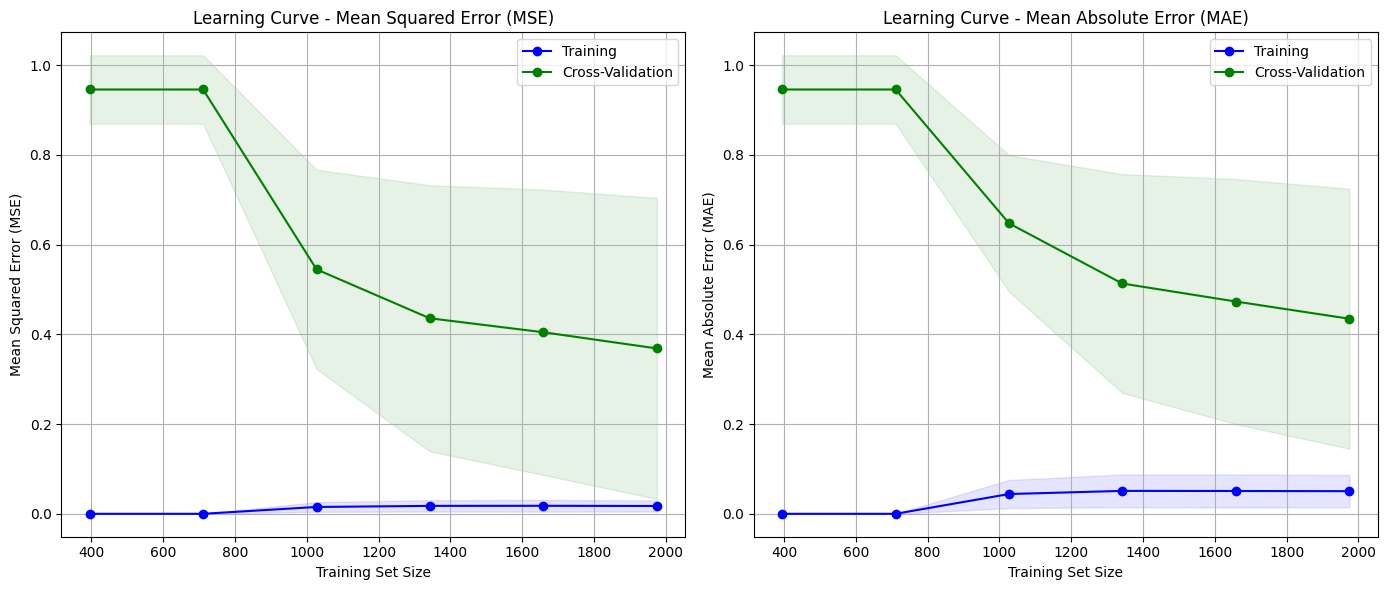

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

def plot_learning_curve(estimator, X, y, metric, metric_name, ax, cv=3, n_jobs=2, train_sizes=np.linspace(0.2, 1.0, 6)):
    """
    Plots a learning curve for the given estimator and dataset using the specified metric.

    Optimizations:
    - Reduced train sizes to 6 values
    - Reduced cross-validation folds to 3
    - Limited parallel jobs to 2
    """

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(metric)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    ax.plot(train_sizes, train_mean, 'o-', color="blue", label="Training")
    ax.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-Validation")

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")

    ax.set_title(f"Learning Curve - {metric_name}")
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel(metric_name)
    ax.legend(loc="best")
    ax.grid()

# Optimized Bagging Regressor
bagging_regressor = BaggingRegressor(
    estimator=DecisionTreeRegressor(), 
    n_estimators=5,  # Reduced from 10 to 5
    max_samples=0.8,  # Uses 80% of data per tree
    random_state=42
)

# Create subplots for MSE and MAE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot learning curves for MSE and MAE
plot_learning_curve(bagging_regressor, X, y, mean_squared_error, "Mean Squared Error (MSE)", axes[0])
plot_learning_curve(bagging_regressor, X, y, mean_absolute_error, "Mean Absolute Error (MAE)", axes[1])

plt.tight_layout()
plt.show()
